# NequIP Tutorial 
This is an implementation of an NequIP energy and force prediction model in python. 
The trained model is deployed and integrated into LAMMPS MD engine to run an accelerated simulation on a single molecule.
Questions? How does the integration works? How to setup LAMMPS simulation? How to determine performance (accuracy) of the model?

In [1]:
# Import modules
import torch
torch.set_default_dtype(torch.float32)
import numpy as np
import logging
import pprint
from nequip.utils.config import Config
#from nequip.train.trainer import Trainer
from nequip.data import AtomicDataDict
from nequip.data import AtomicData
from nequip.data import dataset_from_config
from ase.io import read, write

## Download and Visualize Molecule Dataset

In [57]:
# Remove existing sample folders and download molecule dataset
!rm -rf ./results/
!rm -rf ./benchmark_data
!rm *.zip
!rm *.npz
!mkdir benchmark_data
!curl http://quantum-machine.org/gdml/data/npz/toluene_ccsd_t.zip -o outfile.zip
!unzip outfile.zip
!y | rm -rf __MACOSX outfile outfile.zip
!mv toluene* ./benchmark_data
!ls benchmark_data


rm: cannot remove '*.zip': No such file or directory
rm: cannot remove '*.npz': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1020k  100 1020k    0     0   482k      0  0:00:02  0:00:02 --:--:--  482k
Archive:  outfile.zip
  inflating: toluene_ccsd_t-train.npz  
   creating: __MACOSX/
  inflating: __MACOSX/._toluene_ccsd_t-train.npz  
  inflating: toluene_ccsd_t-test.npz  
  inflating: __MACOSX/._toluene_ccsd_t-test.npz  
/usr/bin/sh: 1: y: not found
toluene_ccsd_t-test.npz  toluene_ccsd_t-train.npz


In [ ]:
# Visualize
from ase.io import read
atoms = read('toluene.xyz', index=0)

from ase.visualize import view
view(atoms, viewer='x3d')

## Set torch geometric training dataset

In [2]:
# from nequip.data.dataset import NpzDataset
# dataset = NpzDataset('./tutorial_results/')
# # logging.info(f"Successfully loaded the data set of type {dataset}...")
npz_files = np.load('benchmark_data/toluene_ccsd_t-train.npz')
npz_files['E'].shape
npz_files['z']
npz_files['name']
print(npz_files.files)
print(npz_files['R'].shape)

['E', 'name', 'F', 'theory', 'R', 'z', 'type', 'md5']
(1000, 15, 3)


In [60]:
# Load config file
config = Config.from_file('./example.yaml')
pprint.pprint(config.as_dict())

{'BesselBasis_trainable': True,
 'PolynomialCutoff_p': 6,
 'append': True,
 'avg_num_neighbors': 'auto',
 'batch_size': 5,
 'chemical_symbols': ['H', 'C'],
 'conv_to_output_hidden_irreps_out': '16x0e',
 'dataset': 'npz',
 'dataset_file_name': './benchmark_data/toluene_ccsd_t-train.npz',
 'dataset_seed': 456,
 'dataset_url': 'http://quantum-machine.org/gdml/data/npz/toluene_ccsd_t.zip',
 'default_dtype': 'float32',
 'early_stopping_lower_bounds': {'LR': 1e-05},
 'early_stopping_patiences': {'validation_loss': 50},
 'ema_decay': 0.99,
 'ema_use_num_updates': True,
 'feature_irreps_hidden': '16x0o + 16x0e + 16x1o + 16x1e',
 'invariant_layers': 2,
 'invariant_neurons': 64,
 'irreps_edge_sh': '0e + 1o',
 'key_mapping': {'E': 'total_energy',
                 'F': 'forces',
                 'R': 'pos',
                 'z': 'atomic_numbers'},
 'l_max': 2,
 'learning_rate': 0.005,
 'log_batch_freq': 10,
 'log_epoch_freq': 1,
 'loss_coeffs': {'forces': 1, 'total_energy': [1, 'PerAtomMSELoss']},

In [61]:
# Instantiate Trainer object trainer with a config file. The trainer handles training as well as call back functions for logging, model saving, and early stopping.
from nequip.train.trainer_wandb import TrainerWandB as Trainer
trainer = Trainer(model=None, **dict(config))
trainer.kwargs

Torch device: cpu


{'root': 'results/toluene',
 'run_name': 'example-run-toluene',
 'append': True,
 'default_dtype': 'float32',
 'r_max': 4.0,
 'num_layers': 4,
 'l_max': 2,
 'parity': True,
 'num_features': 32,
 'nonlinearity_type': 'gate',
 'nonlinearity_scalars': {'e': 'silu', 'o': 'tanh'},
 'nonlinearity_gates': {'e': 'silu', 'o': 'tanh'},
 'num_basis': 8,
 'BesselBasis_trainable': True,
 'PolynomialCutoff_p': 6,
 'invariant_layers': 2,
 'invariant_neurons': 64,
 'avg_num_neighbors': 'auto',
 'use_sc': True,
 'dataset': 'npz',
 'dataset_url': 'http://quantum-machine.org/gdml/data/npz/toluene_ccsd_t.zip',
 'dataset_file_name': './benchmark_data/toluene_ccsd_t-train.npz',
 'key_mapping': {'z': 'atomic_numbers',
  'E': 'total_energy',
  'F': 'forces',
  'R': 'pos'},
 'npz_fixed_field_keys': ['atomic_numbers'],
 'chemical_symbols': ['H', 'C'],
 'num_types': 2,
 'feature_irreps_hidden': '16x0o + 16x0e + 16x1o + 16x1e',
 'irreps_edge_sh': '0e + 1o',
 'conv_to_output_hidden_irreps_out': '16x0e',
 'wandb': 

In [5]:
dataset = dataset_from_config(config, prefix='dataset')
logging.info(f"Successfully loaded the data set of type {dataset}...")

Successfully loaded the data set of type NpzDataset(1000)...


In [6]:
trainer.set_dataset(dataset)
trainer.dataset_train.get_data()[0].keys()

dict_keys(['total_energy', 'forces', 'pos'])

In [7]:
# Normalize training dataset, compute statistics
(
    (forces_std,),
    (energies_mean, energies_std)
) = trainer.dataset_train.statistics(
    fields=[
        AtomicDataDict.FORCE_KEY,
        AtomicDataDict.TOTAL_ENERGY_KEY
    ],
    modes=["rms", "mean_std"],
)
print(f"Forces standard deviation: {forces_std.item()}")
print(f"Eneriges standard deiation: {energies_std.item()}")
print(f"Energies mean: {energies_mean.item()}")

Forces standard deviation: 30.046512603759766
Eneriges standard deiation: 5.970083236694336
Energies mean: -169792.875


In [8]:
# energy_minus_mean = result[0]['total_energy'] - energies_mean.numpy()
# energy_normalized = energy_minus_mean * energies_std.numpy()
# trainer.dataset_train.get_data()[0]['total_energy'] = energy_normalized 

In [9]:
trainer.dataset_train[0]['total_energy']

tensor([-169796.0938])

## Force and Energy Prediction

In [10]:
# Create model
from nequip.model._grads import ForceOutput
from typing import Optional
import logging
from e3nn import o3
from nequip.data import AtomicDataDict, AtomicDataset
from nequip.nn import (
    SequentialGraphNetwork,
    AtomwiseLinear,
    AtomwiseReduce,
    ConvNetLayer,
)
from nequip.nn.embedding import (
    OneHotAtomEncoding,
    RadialBasisEdgeEncoding,
    SphericalHarmonicEdgeAttrs,
)

from nequip.model import builder_utils

def EnergyModel(
    config, initialize: bool, dataset: Optional[AtomicDataset] = None
) -> SequentialGraphNetwork:
    """Base default energy model archetecture.

    For minimal and full configuration option listings, see ``minimal.yaml`` and ``example.yaml``.
    """
    logging.debug("Start building the network model")

    builder_utils.add_avg_num_neighbors(
        config=config, initialize=initialize, dataset=dataset
    )

    num_layers = config.get("num_layers", 3)

    layers = {
        # -- Encode --
        "one_hot": OneHotAtomEncoding,
        "spharm_edges": SphericalHarmonicEdgeAttrs,
        "radial_basis": RadialBasisEdgeEncoding,
        # -- Embed features --
        "chemical_embedding": AtomwiseLinear,
    }

    # add convnet layers
    # insertion preserves order
    for layer_i in range(num_layers):
        layers[f"layer{layer_i}_convnet"] = ConvNetLayer

    # .update also maintains insertion order
    layers.update(
        {
            # TODO: the next linear throws out all L > 0, don't create them in the last layer of convnet
            # -- output block --
            "conv_to_output_hidden": AtomwiseLinear,
            "output_hidden_to_scalar": (
                AtomwiseLinear,
                dict(irreps_out="1x0e", out_field=AtomicDataDict.PER_ATOM_ENERGY_KEY),
            ),
        }
    )

    layers["total_energy_sum"] = (
        AtomwiseReduce,
        dict(
            reduce="sum",
            field=AtomicDataDict.PER_ATOM_ENERGY_KEY,
            out_field=AtomicDataDict.TOTAL_ENERGY_KEY,
        ),
    )

    return SequentialGraphNetwork.from_parameters(
        shared_params=config,
        layers=layers,
    )

In [11]:
# Instantiate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
energy_model = EnergyModel(config, initialize=True, dataset=dataset)
force_model = ForceOutput(energy_model)
#print(force_model)

In [12]:
from nequip.nn import RescaleOutput
final_model = RescaleOutput(
    model=force_model,
    scale_keys=[AtomicDataDict.TOTAL_ENERGY_KEY, AtomicDataDict.FORCE_KEY],
    scale_by=forces_std,
    shift_keys=AtomicDataDict.TOTAL_ENERGY_KEY,
    shift_by=energies_mean,
).to(device)

In [13]:
import wandb
wandb.login()

wandb: Currently logged in as: josiahbjorgaard. Use `wandb login --relogin` to force relogin


True

In [14]:
run = wandb.init(
    # Set the project where this run will be logged
    project="nequip-tutorial",
    # Track hyperparameters and run metadata
    config=config)

In [15]:
# Training
trainer.model = final_model
trainer.train()

Number of weights: 61696
Number of trainable weights: 61696
! Starting training ...

validation
# Epoch batch         loss       loss_f       loss_e        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
      0     5         1.11         1.11     0.000296         22.8         31.6         15.7           31         23.3         20.4         40.9         30.6         6.06        0.404


  Initialization     #    Epoch      wal       LR       loss_f       loss_e         loss        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
! Initial Validation          0    2.270    0.005         1.04     0.000224         1.04         22.2         30.6         15.4           30         22.7         20.2         39.2         29.7         5.06        0.337
Wall time: 2.271973335999064
! Best model        0    1.036

training
# Epoch batch         loss  

      5     5       0.0816       0.0815      0.00012         6.29         8.58         3.84         9.08         6.46         4.94         11.4         8.17         4.44        0.296


  Train      #    Epoch      wal       LR       loss_f       loss_e         loss        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
! Train               5   16.464    0.005       0.0863     0.000484       0.0868         6.56         8.83         4.39         9.04         6.72         5.66         11.4         8.54          8.6        0.573
! Validation          5   16.464    0.005       0.0764     8.76e-05       0.0765          6.1         8.31         3.93         8.58         6.25         5.04         10.9         7.97         3.57        0.238
Wall time: 16.467291888002364
! Best model        5    0.076

training
# Epoch batch         loss       loss_f       loss_e        f_mae       f_rmse      H_f_mae      C_f_mae  psavg



  Train      #    Epoch      wal       LR       loss_f       loss_e         loss        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
! Train              10   32.970    0.005       0.0307     7.08e-05       0.0307         3.97         5.26         3.28         4.76         4.02         4.37         6.12         5.25         3.16        0.211
! Validation         10   32.970    0.005       0.0273     1.97e-05       0.0273         3.76         4.96         2.96         4.66         3.81         3.89         5.96         4.92         1.56        0.104
Wall time: 32.97340771200106
! Best model       10    0.027

training
# Epoch batch         loss       loss_f       loss_e        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
     11    10       0.0344       0.0343     9.24e-05         4.13         5.56         3.31         5.07        

! Train              15   47.744    0.005       0.0195      7.5e-05       0.0196          3.2          4.2         2.71         3.76         3.23          3.6          4.8          4.2         3.09        0.206
! Validation         15   47.744    0.005       0.0176     1.15e-05       0.0176         3.03         3.98         2.58         3.55         3.07         3.37         4.59         3.98         1.24       0.0827
Wall time: 47.74673959000211
! Best model       15    0.018

training
# Epoch batch         loss       loss_f       loss_e        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
     16    10       0.0206       0.0205     8.72e-05         3.13          4.3          2.8         3.52         3.16         3.84         4.77         4.31         3.32        0.221
     16    20       0.0208       0.0208     3.85e-05         3.48         4.33         3.14         3.87         3.51            4         4.6

! Validation         20   58.368    0.005       0.0146     9.13e-06       0.0146         2.78         3.63          2.4         3.21          2.8          3.1         4.16         3.63         1.07       0.0715
Wall time: 58.37118184599967
! Best model       20    0.015

training
# Epoch batch         loss       loss_f       loss_e        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
     21    10       0.0169       0.0169     4.59e-05         2.91          3.9         2.62         3.24         2.93         3.58         4.24         3.91         2.04        0.136
     21    20       0.0178       0.0178     3.58e-05         3.18         4.01         2.83         3.57          3.2         3.72         4.32         4.02         2.23        0.149

validation
# Epoch batch         loss       loss_f       loss_e        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse  

Wall time: 72.55659110000124
! Best model       25    0.013

training
# Epoch batch         loss       loss_f       loss_e        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
     26    10        0.015       0.0149     3.18e-05         2.77         3.67         2.51         3.06         2.79         3.41         3.96         3.68         1.99        0.133
     26    20       0.0158       0.0158     2.77e-05         2.95         3.78          2.6         3.36         2.98         3.48         4.09         3.78         1.95         0.13

validation
# Epoch batch         loss       loss_f       loss_e        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
     26     5       0.0118       0.0118      1.1e-05         2.52         3.26         2.15         2.93         2.54         2.74         3.77         3.26         1.35       0.0902


 


training
# Epoch batch         loss       loss_f       loss_e        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
     31    10       0.0135       0.0135     3.56e-05         2.66         3.49         2.41         2.93         2.67         3.26         3.73          3.5         2.51        0.167
     31    20       0.0139       0.0139     1.95e-05         2.75         3.54         2.41         3.14         2.77         3.27         3.83         3.55         1.64         0.11

validation
# Epoch batch         loss       loss_f       loss_e        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
     31     5       0.0106       0.0105     1.01e-05         2.38         3.09         2.03         2.77          2.4         2.62         3.54         3.08         1.29       0.0859


  Train      #    Epoch      wal       LR       loss_f       

     36    10        0.012       0.0119     4.11e-05         2.52         3.28         2.32         2.74         2.53         3.13         3.45         3.29         2.78        0.185
     36    20        0.012        0.012     1.19e-05         2.54         3.29         2.23         2.91         2.57         3.07         3.53          3.3         1.28       0.0854

validation
# Epoch batch         loss       loss_f       loss_e        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
     36     5      0.00958      0.00957     8.94e-06         2.25         2.94         1.94         2.61         2.28         2.52         3.36         2.94         1.21       0.0804


  Train      #    Epoch      wal       LR       loss_f       loss_e         loss        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
! Train              36   97.760    0.005  

     41    20       0.0101       0.0101     6.93e-06          2.3         3.02         2.07         2.57         2.32         2.88         3.18         3.03         1.04       0.0692

validation
# Epoch batch         loss       loss_f       loss_e        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
     41     5      0.00875      0.00874     7.78e-06         2.14         2.81         1.85         2.47         2.16         2.42          3.2         2.81         1.12       0.0745


  Train      #    Epoch      wal       LR       loss_f       loss_e         loss        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
! Train              41  111.905    0.005      0.00946     1.97e-05      0.00948         2.23         2.92         1.93         2.57         2.25         2.59         3.26         2.93         1.54        0.103
! Validation   


validation
# Epoch batch         loss       loss_f       loss_e        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
     46     5      0.00798      0.00797     6.42e-06         2.04         2.68         1.77         2.36         2.06         2.32         3.05         2.68         1.01       0.0672


  Train      #    Epoch      wal       LR       loss_f       loss_e         loss        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
! Train              46  122.729    0.005      0.00805     1.22e-05      0.00806         2.05          2.7         1.79         2.34         2.07         2.42         2.98          2.7         1.24       0.0827
! Validation         46  122.729    0.005      0.00897      5.8e-06      0.00898         2.16         2.85         1.89         2.46         2.18          2.5          3.2         2.85        0.843 

     51     5      0.00722      0.00721     4.94e-06         1.94         2.55         1.66         2.26         1.96          2.2          2.9         2.55        0.872       0.0581


  Train      #    Epoch      wal       LR       loss_f       loss_e         loss        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
! Train              51  135.074    0.005      0.00729     1.21e-05       0.0073         1.96         2.57          1.7         2.25         1.97         2.27         2.86         2.57         1.24       0.0829
! Validation         51  135.074    0.005      0.00814     5.35e-06      0.00814         2.06         2.71         1.79         2.37         2.08         2.38         3.04         2.71        0.787       0.0525
Wall time: 135.08038762400247
! Best model       51    0.008

training
# Epoch batch         loss       loss_f       loss_e        f_mae       f_rmse      H_f_mae      C_f_mae  psavg



  Train      #    Epoch      wal       LR       loss_f       loss_e         loss        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
! Train              56  151.901    0.005      0.00674     1.53e-05      0.00675         1.89         2.47         1.62         2.19          1.9         2.15         2.78         2.47         1.41       0.0941
! Validation         56  151.901    0.005      0.00738     4.92e-06      0.00739         1.96         2.58         1.69         2.28         1.98         2.26         2.91         2.58        0.742       0.0495
Wall time: 151.90556310399552
! Best model       56    0.007

training
# Epoch batch         loss       loss_f       loss_e        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
     57    10      0.00732      0.00731     1.84e-05         1.95         2.57         1.74         2.19       

! Train              61  163.686    0.005      0.00615     1.64e-05      0.00616          1.8         2.36         1.52         2.12         1.82         2.03         2.68         2.35         1.45       0.0969
! Validation         61  163.686    0.005      0.00674     4.48e-06      0.00675         1.88         2.47         1.59         2.21          1.9         2.13          2.8         2.47        0.709       0.0473
Wall time: 163.6892322720014
! Best model       61    0.007

training
# Epoch batch         loss       loss_f       loss_e        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
     62    10      0.00696      0.00694     1.95e-05         1.91          2.5         1.66          2.2         1.93         2.26         2.75         2.51         1.77        0.118
     62    20      0.00722      0.00721     1.09e-05         1.98         2.55          1.8         2.19            2         2.32         2.7

! Validation         66  174.697    0.005      0.00619        4e-06      0.00619          1.8         2.36          1.5         2.13         1.82         2.01         2.71         2.36        0.674        0.045
Wall time: 174.70303757299553
! Best model       66    0.006

training
# Epoch batch         loss       loss_f       loss_e        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae
     67    10      0.00671      0.00668     2.27e-05         1.88         2.46         1.57         2.25         1.91         2.14         2.77         2.46         1.93        0.129
     67    20      0.00674      0.00673     8.33e-06         1.94         2.46         1.78         2.13         1.95         2.25         2.69         2.47         1.25       0.0835

validation
# Epoch batch         loss       loss_f       loss_e        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse 

Wall time: 192.53644884999812
! Best model       71    0.006

training
# Epoch batch         loss       loss_f       loss_e        f_mae       f_rmse      H_f_mae      C_f_mae  psavg_f_mae     H_f_rmse     C_f_rmse psavg_f_rmse        e_mae      e/N_mae


KeyboardInterrupt: 

## Inference

In [58]:
# Inference on last frame in dataset
print(config.dataset_file_name)
toluene_data = np.load(config.dataset_file_name)
r = toluene_data['R'][0]
forces = toluene_data['F'][0]

ATOMIC_NUMBERS_KEY = torch.Tensor(torch.from_numpy(toluene_data['z'].astype(np.float32))).to(torch.int64)

#The atomic types for toluene as trained in the model are 1: Carbon, 0: Hydrogen, 
# and so those must match here. Previously, all atoms were mapped to type 0, causing a mismatch between
# the captioned forces.
atom_types = (ATOMIC_NUMBERS_KEY == 6).to(torch.int64)
data = AtomicData.from_points(
    pos=r,
    r_max=config['r_max'], 
    **{AtomicDataDict.ATOMIC_NUMBERS_KEY: ATOMIC_NUMBERS_KEY,
    AtomicDataDict.ATOM_TYPE_KEY: atom_types
    }
)
#print(data.atomic_numbers)

./benchmark_data/toluene_ccsd_t-train.npz


In [61]:
force_model.train(); 
pred = force_model(AtomicData.to_AtomicDataDict(data))['forces']

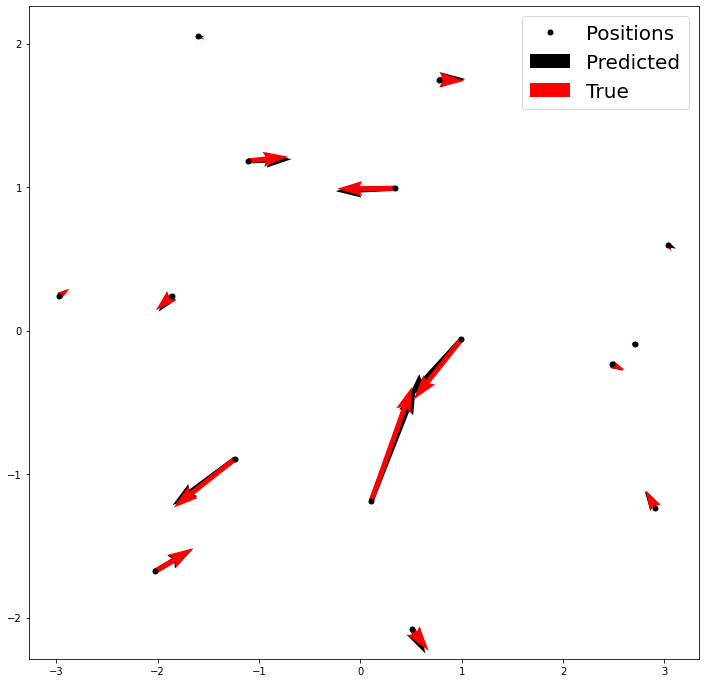

In [59]:
# Plot original and predicted force vectors
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 12))

plt.plot(
    r[:, 0],
    r[:, 1],
    '.k',
    markersize=10,
)

plt.quiver(
    r[:, 0],
    r[:, 1],
    pred[:, 0].detach().numpy(),
    pred[:, 1].detach().numpy(),
    norm=None
)

plt.quiver(
    r[:, 0], 
    r[:, 1], 
    forces[:, 0],
    forces[:, 1],
    color='red', 
    norm=None
)

plt.legend(['Positions', 'Predicted', 'True'], prop={'size': 20})
plt.show()

## MD Simulation with LAMMPS

In [ ]:
# # Compile lammps
# !wget "https://github.com/lammps/lammps/archive/stable.zip"
# !unzip -q stable.zip
# !rm stable.zip
# !mv lammps-stable lammps
# !wget "https://github.com/mir-group/pair_nequip/archive/main.zip"
# !unzip -q main.zip
# !rm main.zip
# !mv pair_nequip-main pair_nequip
# !cd pair_nequip && ./patch_lammps.sh ../lammps


In [1]:
# compile lammps
!git clone -b stable_29Sep2021_update2 --depth 1 https://github.com/lammps/lammps.git
!wget "https://github.com/mir-group/pair_nequip/archive/main.zip"
!unzip -q main.zip
!rm main.zip
!mv pair_nequip-main pair_nequip
!cd pair_nequip && ./patch_lammps.sh ../lammps
# !pip install mkl mkl-include
!cd lammps && mkdir -p build && cd build && cmake ../cmake -D CMAKE_PREFIX_PATH=`python -c 'import torch;print(torch.utils.cmake_prefix_path)'` && make -j4

Cloning into 'lammps'...
remote: Enumerating objects: 11732, done.
remote: Counting objects: 100% (11732/11732), done.
remote: Compressing objects: 100% (8603/8603), done.
remote: Total 11732 (delta 3943), reused 6318 (delta 2930), pack-reused 0
Receiving objects: 100% (11732/11732), 110.00 MiB | 12.46 MiB/s, done.
Resolving deltas: 100% (3943/3943), done.
Note: switching to '7586adbb6a61254125992709ef2fda9134cfca6c'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

Updating files: 100% (11058/11058), done.
--2023-03-22 10:50:

In [ ]:
%pip install mkl mkl-include

In [ ]:
import torch
print(torch.utils.cmake_prefix_path)

In [ ]:
# mkl install not working with pip
%pip install mkl mkl-include
!cd lammps && mkdir -p build && cd build && cmake ../cmake -DCMAKE_PREFIX_PATH=`python -c 'import torch;print(torch.utils.cmake_prefix_path)'` && make -j4


In [ ]:
# how to setup lammps config file?
lammps_input_minimize = """
units	real
atom_style atomic
newton off
thermo 1
read_data structure.data

pair_style	nequip
pair_coeff	* * ../toluene-deployed.pth C H 
mass            1 15.9994
mass            2 1.00794

neighbor 1.0 bin
neigh_modify delay 5 every 1

minimize 0.0 1.0e-8 10000 1000000
write_dump all custom output.dump id type x y z fx fy fz
"""
!mkdir lammps_run
with open("lammps_run/toluene_minimize.in", "w") as f:
    f.write(lammps_input_minimize)

In [ ]:
toluene_example = """15
 Lattice="100.0 0.0 0.0 0.0 100.0 0.0 0.0 0.0 100.0" Properties=species:S:1:pos:R:3 -169777.5840406276=T pbc="F F F"
 C       52.48936904      49.86911725      50.09520748
 C       51.01088202      49.89609925      50.17978049
 C       50.36647401      50.04650925      48.96054247
 C       48.95673398      50.29576626      48.71580846
 C       48.04533296      50.26023426      49.82589448
 C       48.70932398      49.85770925      51.01923950
 C       50.06326400      49.77782925      51.25691751
 H       52.94467905      50.48672926      50.86545150
 H       52.89060405      48.87175023      50.14480949
 H       53.02173405      50.05890725      49.03968247
 H       51.01439802      50.38234726      48.05314045
 H       48.80598498      50.64314926      47.68195744
 H       46.96754695      50.20586626      49.53998848
 H       48.16716997      49.75850325      51.88622952
 H       50.45791001      49.55387424      52.15303052
 """

with open('toluene.xyz', 'w') as f: 
    f.write(toluene_example)

In [ ]:
# Read as ASE objects
atoms = read('toluene.xyz', format='extxyz')

# Perturb positions
p = atoms.get_positions()
p += np.random.rand(15, 3) * 0.5
atoms.set_positions(p)
atoms.set_pbc(False)

# Write to a LAMMPS file
write("lammps_run/structure.data", atoms, format="lammps-data")

In [ ]:
# from ase.io import read
# atoms = read('toluene.xyz', index=0)
from ase.visualize import view
view(atoms, viewer='x3d')

In [ ]:
!cd lammps_run/ && ../lammps/build/lmp -in toluene_minimize.in